### Importing libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [48]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

### Loading datasets

In [3]:
df1 = pd.read_csv('purchases_monthly.csv')
df2 = pd.read_csv('d2d_monthly.csv')
purchases_monthly = pd.read_csv('purchases_monthly.csv')
d2d_monthly = pd.read_csv('d2d_monthly.csv')

In [4]:
purchases_monthly.head(5)

,dim_product_sk,year_month,amount,quantity,year,month
0,5,2019-01,4008.34,95.0,2019,1
1,5,2019-02,8282.05,197.0,2019,2
2,5,2019-03,5168.46,123.0,2019,3
3,5,2019-04,3659.85,87.0,2019,4
4,5,2019-05,6643.27,158.0,2019,5


In [5]:
d2d_monthly.head(5)

,dim_product_sk,year_month,amount,quantity,year,month
0,1,2019-01,0.0,0.0,2019,1
1,1,2019-02,0.0,0.0,2019,2
2,1,2019-03,0.0,0.0,2019,3
3,1,2019-04,0.0,0.0,2019,4
4,1,2019-05,0.0,0.0,2019,5


### Data information

In [6]:
purchases_monthly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180831 entries, 0 to 180830
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   dim_product_sk  180831 non-null  int64  
 1   year_month      180831 non-null  object 
 2   amount          180831 non-null  float64
 3   quantity        180831 non-null  float64
 4   year            180831 non-null  int64  
 5   month           180831 non-null  int64  
dtypes: float64(2), int64(3), object(1)
memory usage: 8.3+ MB


In [7]:
d2d_monthly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137776 entries, 0 to 137775
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   dim_product_sk  137776 non-null  int64  
 1   year_month      137776 non-null  object 
 2   amount          137776 non-null  float64
 3   quantity        137776 non-null  float64
 4   year            137776 non-null  int64  
 5   month           137776 non-null  int64  
dtypes: float64(2), int64(3), object(1)
memory usage: 6.3+ MB


### Data cleaning

### Check for missing values

In [8]:
purchases_monthly.isna().sum()

dim_product_sk    0
year_month        0
amount            0
quantity          0
year              0
month             0
dtype: int64

In [9]:
d2d_monthly.isna().sum()

dim_product_sk    0
year_month        0
amount            0
quantity          0
year              0
month             0
dtype: int64

### Check for duplicate values

In [10]:
purchases_monthly.duplicated(subset=['dim_product_sk', 'year_month']).any()

False

In [11]:
d2d_monthly.duplicated(subset=['dim_product_sk', 'year_month']).any()

False

No duplicate rows in data.

### Check for negative values

In [12]:
print("Negative quantity rows:", (purchases_monthly['quantity'] < 0).sum())
print("Negative amount rows:", (purchases_monthly['amount'] < 0).sum())

Negative quantity rows: 0
Negative amount rows: 0


In [13]:
print("Negative quantity rows:", (d2d_monthly['quantity'] < 0).sum())
print("Negative amount rows:", (d2d_monthly['amount'] < 0).sum())

Negative quantity rows: 992
Negative amount rows: 997


### Handling negative values

Placing negative values in separate columns, negative values in amount and quantity are representing returns.

In [14]:
d2d_monthly['return_quantity'] = (-d2d_monthly['quantity']).clip(lower=0)
d2d_monthly['return_amount'] = (-d2d_monthly['amount']).clip(lower=0)

d2d_monthly['quantity'] = d2d_monthly['quantity'].clip(lower=0)
d2d_monthly['amount'] = d2d_monthly['amount'].clip(lower=0)

d2d_monthly['return_quantity'] = d2d_monthly['return_quantity'].replace(-0.0, 0.0)
d2d_monthly['return_amount'] = d2d_monthly['return_amount'].replace(-0.0, 0.0)

In [15]:
print("Negative quantity rows:", (d2d_monthly['quantity'] < 0).sum())
print("Negative amount rows:", (d2d_monthly['amount'] < 0).sum())

Negative quantity rows: 0
Negative amount rows: 0


In [16]:
d2d_monthly.sample(5)

,dim_product_sk,year_month,amount,quantity,year,month,return_quantity,return_amount
65121,2245,2021-02,1065.25,25.0,2021,2,0.0,0.0
82200,2736,2022-05,1885.94,19.0,2022,5,0.0,0.0
25183,686,2024-02,280.08,12.0,2024,2,0.0,0.0
17450,417,2024-11,14.52,1.0,2024,11,0.0,0.0
83670,2790,2019-10,2392.20,60.0,2019,10,0.0,0.0


### Quarterly time features

In [17]:
purchases_monthly['year_month'] = pd.to_datetime(purchases_monthly['year_month'])
purchases_monthly['quarter'] = purchases_monthly['year_month'].dt.quarter

In [18]:
purchases_monthly.sample(5)

,dim_product_sk,year_month,amount,quantity,year,month,quarter
67907,2118,2022-11-01,478.92,14.0,2022,11,4
105250,3000,2020-11-01,0.00,0.0,2020,11,4
139534,4684,2020-09-01,4970.04,998.0,2020,9,3
42313,1358,2023-01-01,29.65,1.0,2023,1,1
34527,1040,2019-05-01,1189.98,18.0,2019,5,2


In [19]:
d2d_monthly['year_month'] = pd.to_datetime(d2d_monthly['year_month'])
d2d_monthly['quarter'] = d2d_monthly['year_month'].dt.quarter

In [20]:
d2d_monthly.sample(5)

,dim_product_sk,year_month,amount,quantity,year,month,return_quantity,return_amount,quarter
69868,2315,2021-09-01,1752.30,45.0,2021,9,0.0,0.0,3
124153,5377,2022-09-01,0.00,0.0,2022,9,0.0,0.0,3
98557,4610,2022-09-01,1634.22,63.0,2022,9,0.0,0.0,3
118590,5245,2019-12-01,1663.26,57.0,2019,12,0.0,0.0,4
118948,5249,2023-06-01,5245.41,159.0,2023,6,0.0,0.0,2


### Univariate analysis

### Unique products 

In [21]:
 print(f"Unique products in monthly purchases dataset: {purchases_monthly['dim_product_sk'].nunique()}")
 print(f"Unique products in monthly d2d dataset: {d2d_monthly['dim_product_sk'].nunique()}")

Unique products in monthly purchases dataset: 2289
Unique products in monthly d2d dataset: 1744


### Monthly Purchases

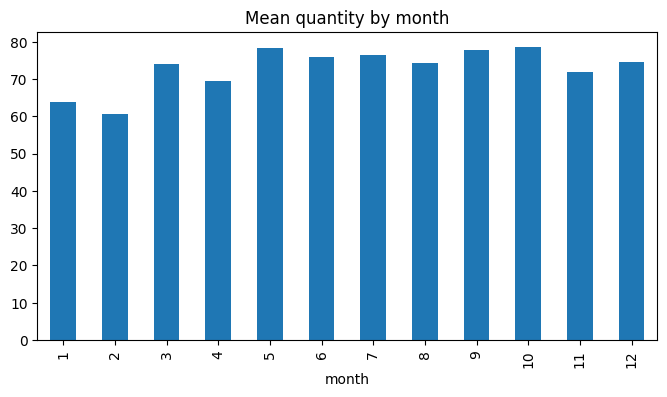

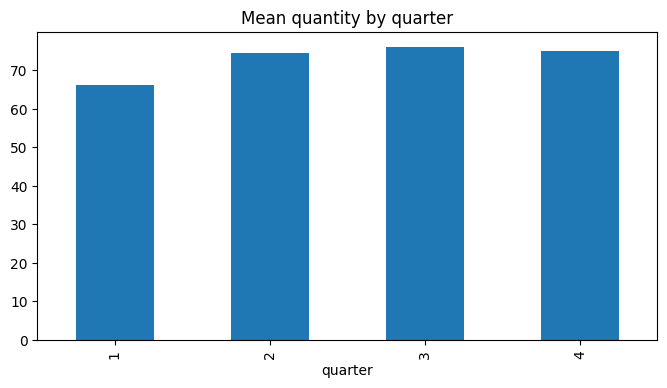

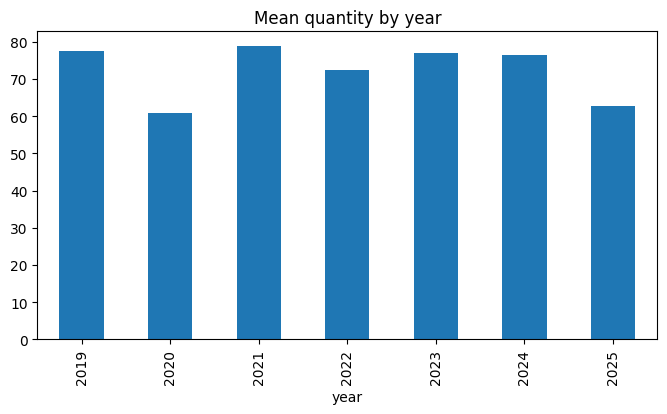

In [22]:
for col in ['month', 'quarter', 'year']:
    purchases_monthly.groupby(col)['quantity'].mean().plot(kind = 'bar', figsize=(8, 4))
    plt.title(f'Mean quantity by {col}')
    plt.show()

### D2D monthly dataset

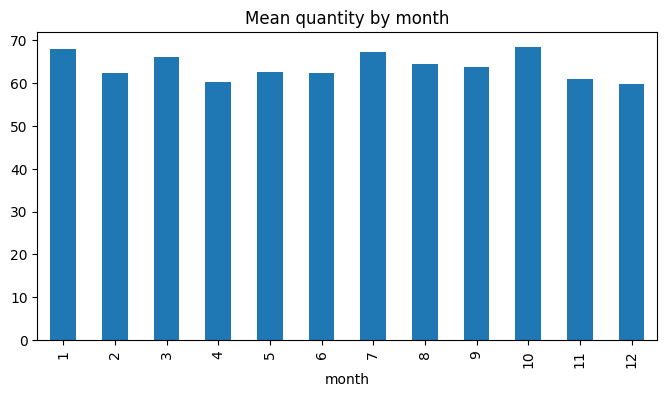

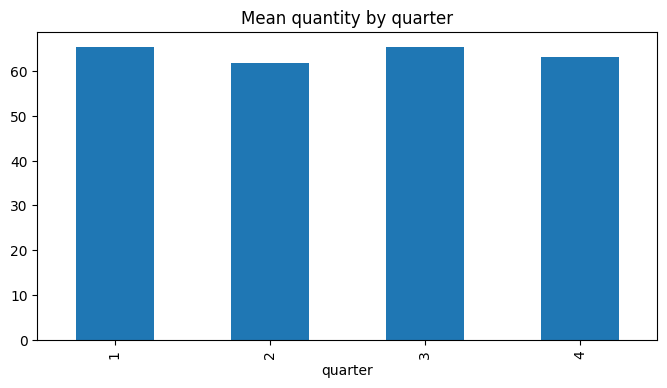

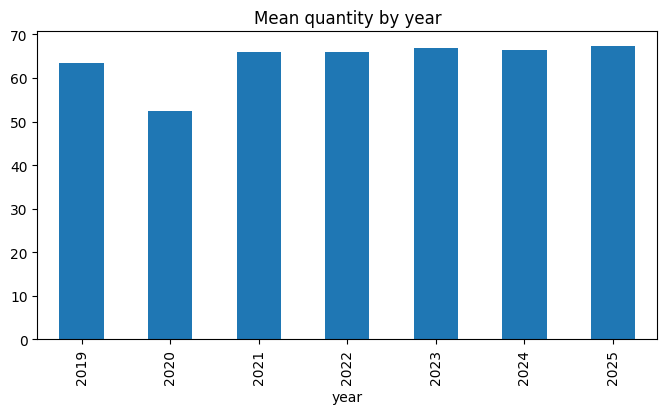

In [23]:
for col in ['month', 'quarter', 'year']:
    d2d_monthly.groupby(col)['quantity'].mean().plot(kind = 'bar', figsize=(8, 4))
    plt.title(f'Mean quantity by {col}')
    plt.show()

### Check for stationarity

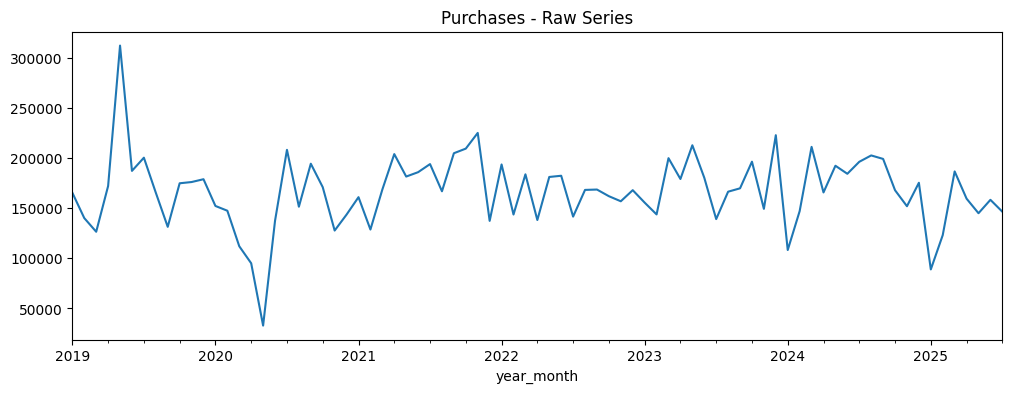

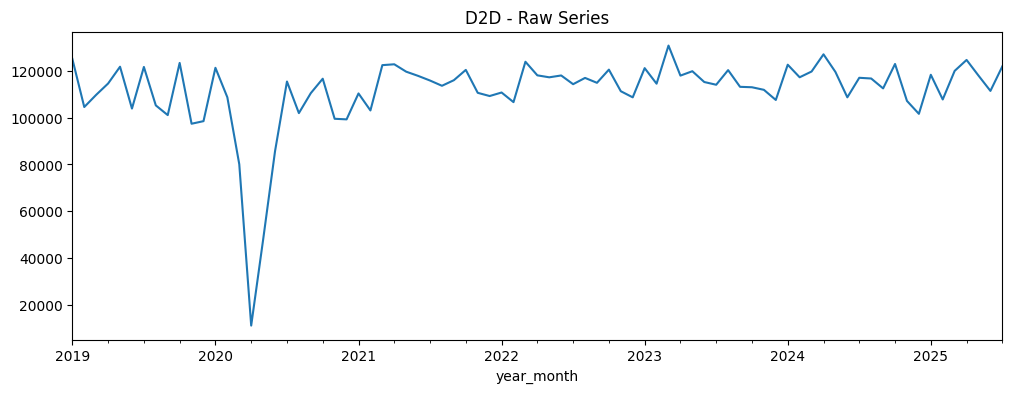

In [24]:
purchase_series = purchases_monthly.groupby('year_month')['quantity'].sum().sort_index()
d2d_series = d2d_monthly.groupby('year_month')['quantity'].sum().sort_index()

purchase_series.plot(title="Purchases - Raw Series", figsize=(12,4))
plt.show()
d2d_series.plot(title="D2D - Raw Series", figsize=(12,4))
plt.show()

### Decomposition

### Visualizing for trends

In [25]:
monthly_purchase = purchases_monthly.groupby('year_month')['quantity'].sum()
monthly_d2d = d2d_monthly.groupby('year_month')['quantity'].sum()

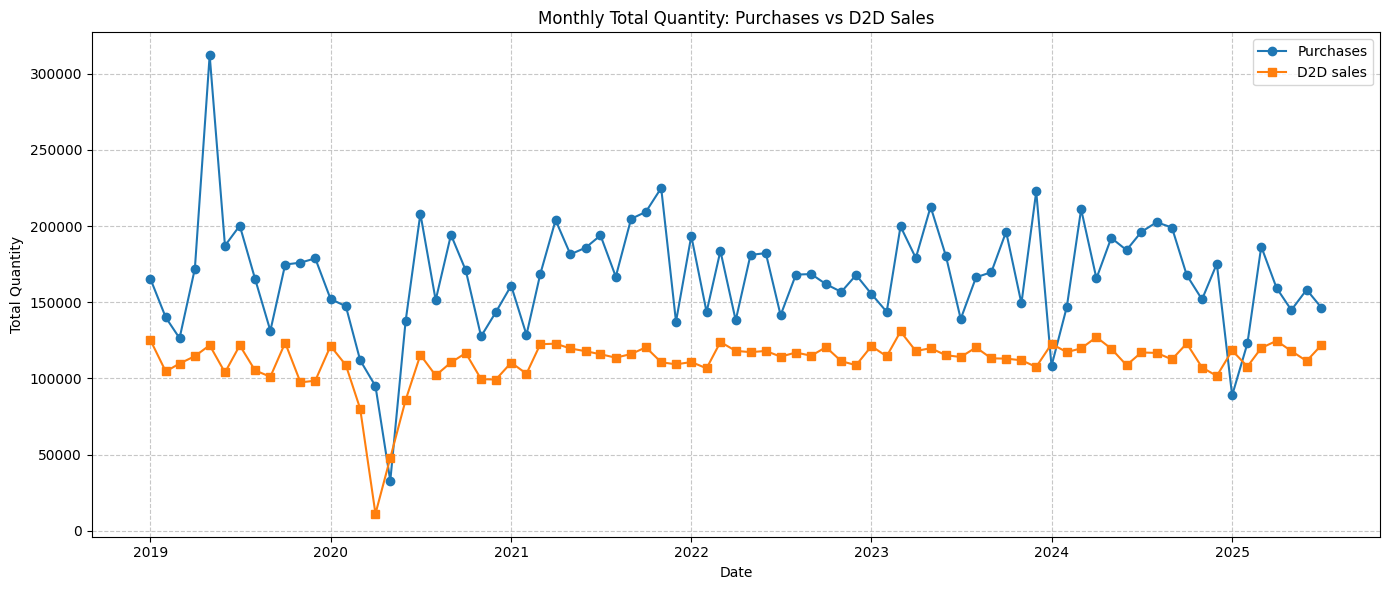

In [26]:
plt.figure(figsize=(14, 6))
plt.plot(monthly_purchase.index, monthly_purchase.values, label="Purchases", marker = 'o')
plt.plot(monthly_d2d.index, monthly_d2d.values, label="D2D sales", marker='s')
plt.title('Monthly Total Quantity: Purchases vs D2D Sales')
plt.xlabel('Date')
plt.ylabel('Total Quantity')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Visualizing for seasonality (Average by month)

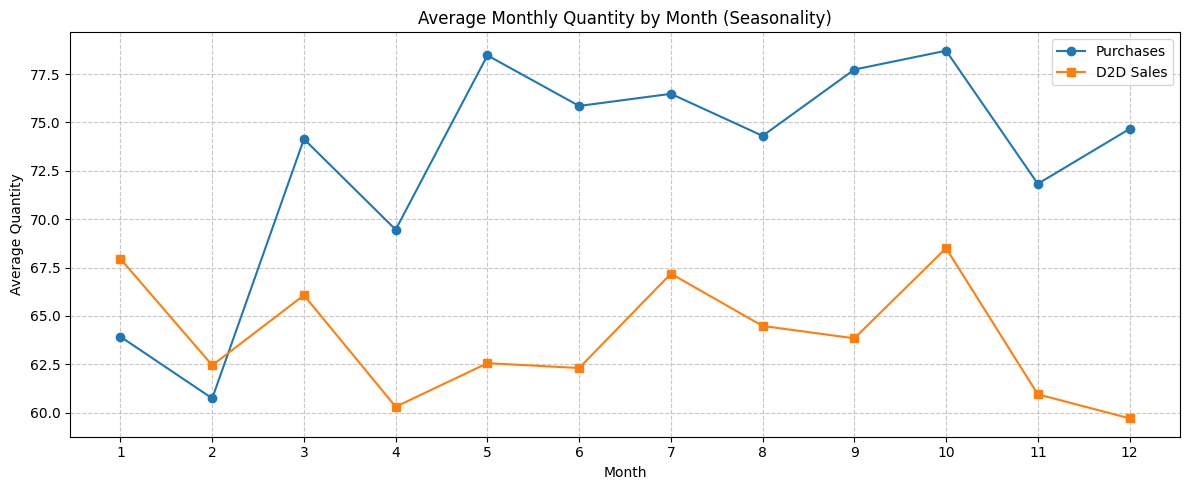

In [27]:
purchase_season = purchases_monthly.groupby('month')['quantity'].mean()
d2d_season = d2d_monthly.groupby('month')['quantity'].mean()

plt.figure(figsize=(12, 5))
plt.plot(purchase_season.index, purchase_season.values, label='Purchases', marker='o')
plt.plot(d2d_season.index, d2d_season.values, label='D2D Sales', marker='s')
plt.title('Average Monthly Quantity by Month (Seasonality)')
plt.xlabel('Month')
plt.ylabel('Average Quantity')
plt.xticks(range(1, 13))
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Visualizing noise

In [91]:
timeseries_decomposition = seasonal_decompose(purchases_monthly['quantity'], model='additive', period=12)

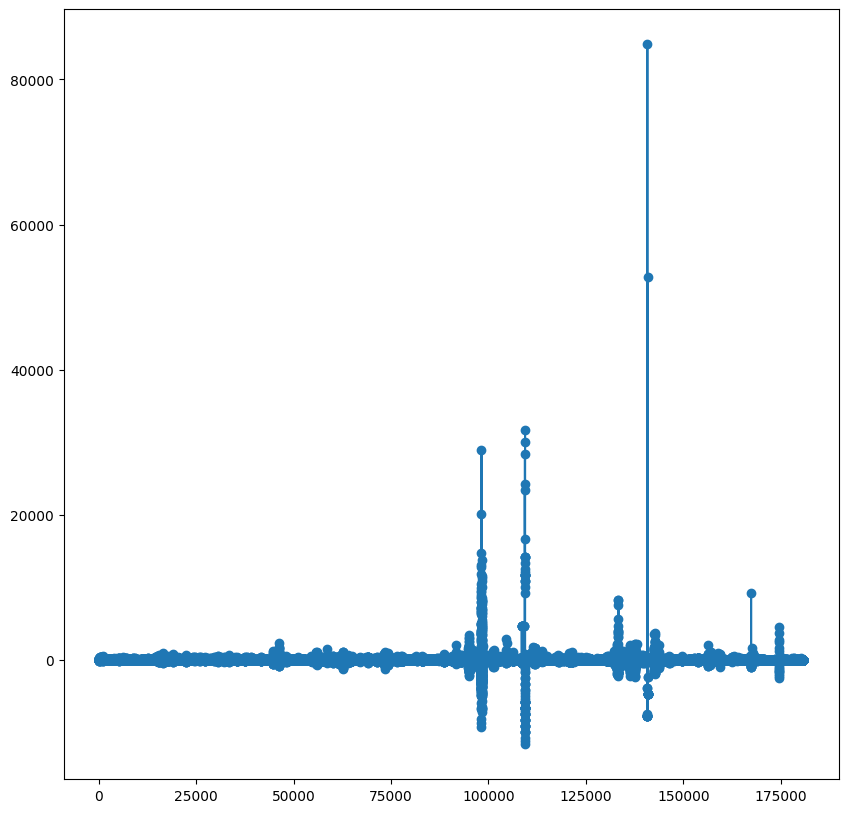

In [92]:
plt.figure(figsize=(10, 10))
residuals = timeseries_decomposition.resid
residuals = residuals.dropna()
plt.plot(residuals.index, residuals, label = "Noise", marker='o')

### ADF test

### ADF Test on Monthly Purchase dataset

In [28]:
df1['year_month'] = pd.to_datetime(df1['year_month'])
df1 = df1.sort_values('year_month')
monthly = df1.groupby('year_month')['amount'].sum()

In [29]:
adf_result_on_monthly_purchase = adfuller(monthly)

In [30]:
print('ADF Test on monthly purchase dataset\n')
print("ADF Test Statistic:", adf_result_on_monthly_purchase[0])
print("p-value:", adf_result_on_monthly_purchase[1])
print("Lags Used:", adf_result_on_monthly_purchase[2])
print("Number of Observations:", adf_result_on_monthly_purchase[3])
print("Critical Values:")
for key, value in adf_result_on_monthly_purchase[4].items():
    print(f"   {key}: {value:.3f}")

if adf_result_on_monthly_purchase[1] <= 0.05:
    print("Series is stationary - reject null hypothesis")
else:
    print("Series is non-stationary - (fail to reject null hypothesis)")

ADF Test on monthly purchase dataset

ADF Test Statistic: -3.010145547809269
p-value: 0.03395773524957551
Lags Used: 2
Number of Observations: 76
Critical Values:
   1%: -3.519
   5%: -2.900
   10%: -2.587
Series is stationary - reject null hypothesis


### ADF Test on Monthly D2D dataset

In [31]:
df2['year_month'] = pd.to_datetime(df2['year_month'])
df2 = df2.sort_values('year_month')
monthly= df2.groupby('year_month')['amount'].sum()

In [32]:
adf_result_on_monthly_d2d = adfuller(monthly)

In [33]:
print('ADF Test on monthly D2D dataset\n')
print("ADF Test Statistic:", adf_result_on_monthly_d2d[0])
print("p-value:", adf_result_on_monthly_d2d[1])
print("Lags Used:", adf_result_on_monthly_d2d[2])
print("Number of Observations:", adf_result_on_monthly_d2d[3])
print("Critical Values:")
for key, value in adf_result_on_monthly_d2d[4].items():
    print(f"   {key}: {value:.3f}")

if adf_result_on_monthly_d2d[1] <= 0.05:
    print("Series is stationary - reject null hypothesis")
else:
    print("Series is non-stationary - (fail to reject null hypothesis)")

ADF Test on monthly D2D dataset

ADF Test Statistic: -3.2704880298255588
p-value: 0.016250313755461595
Lags Used: 0
Number of Observations: 78
Critical Values:
   1%: -3.517
   5%: -2.899
   10%: -2.587
Series is stationary - reject null hypothesis


### Autocorrelation function test

<Figure size 1000x400 with 0 Axes>

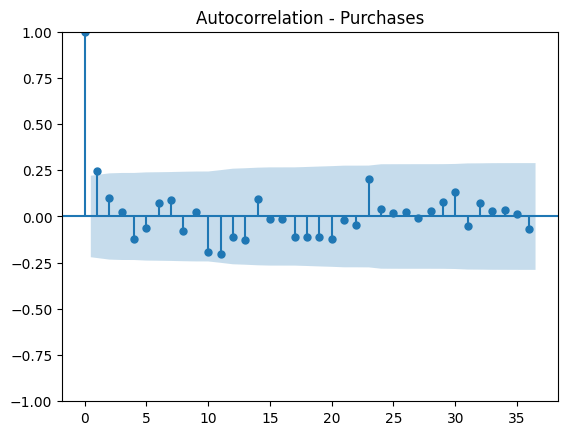

In [34]:
plt.figure(figsize=(10,4))
plot_acf(purchase_series, lags=36) 
plt.title("Autocorrelation - Purchases")
plt.show()

<Figure size 1000x400 with 0 Axes>

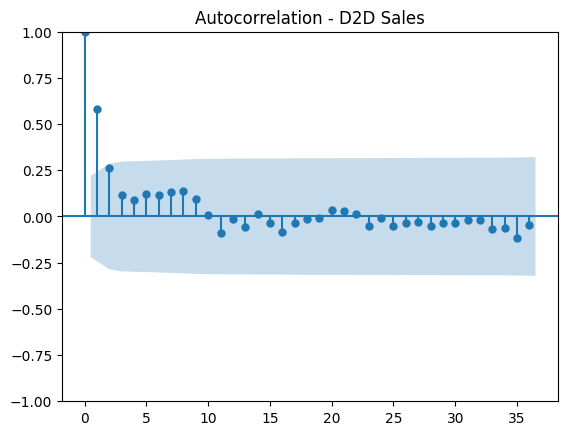

In [35]:
plt.figure(figsize=(10,4))
plot_acf(d2d_series, lags=36)
plt.title("Autocorrelation - D2D Sales")
plt.show()

### Partial Autocorrelation Function test

<Figure size 1000x400 with 0 Axes>

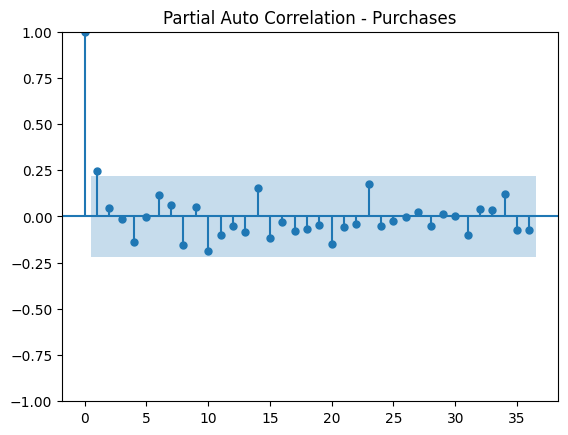

In [95]:
plt.figure(figsize=(10,4))
plot_pacf(purchase_series, lags=36)
plt.title("Partial Auto Correlation - Purchases")
plt.show()

<Figure size 1000x400 with 0 Axes>

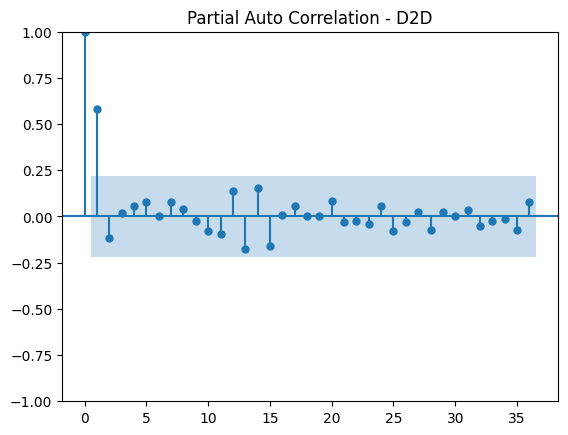

In [96]:
plt.figure(figsize=(10,4))
plot_pacf(d2d_series, lags=36)
plt.title("Partial Auto Correlation - D2D")
plt.show()

### Smoothing using 3-Month Moving Average

In [36]:
monthly_purchase_ma = purchase_series.rolling(window=3).mean()

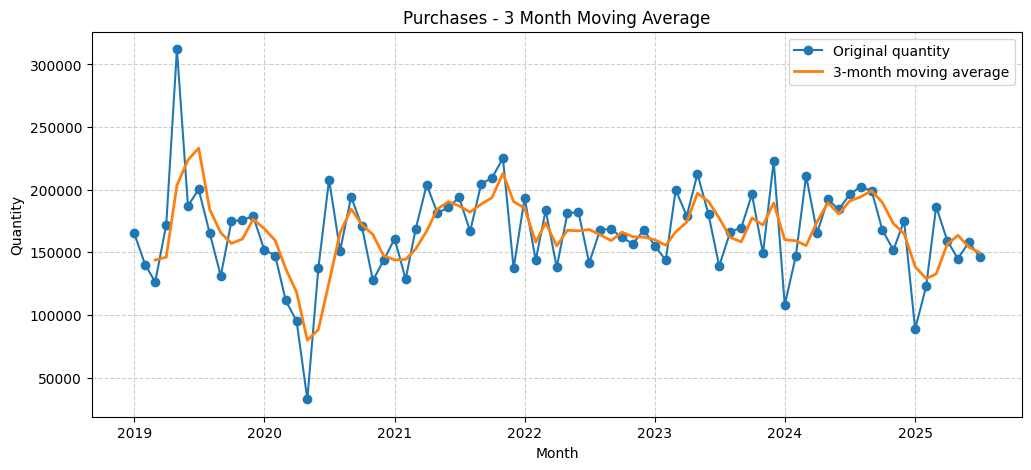

In [37]:
plt.figure(figsize=(12,5))
plt.plot(purchase_series, label="Original quantity", marker='o')
plt.plot(monthly_purchase_ma, label="3-month moving average", linewidth=2)
plt.title("Purchases - 3 Month Moving Average")
plt.xlabel("Month")
plt.ylabel("Quantity")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

In [38]:
monthly_d2d_ma = d2d_series.rolling(window=3).mean()

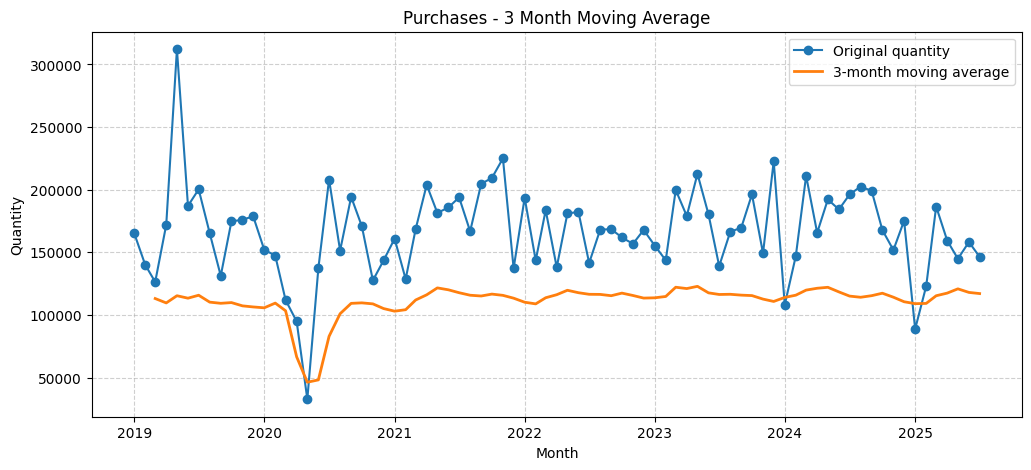

In [39]:
plt.figure(figsize=(12,5))
plt.plot(purchase_series, label="Original quantity", marker='o')
plt.plot(monthly_d2d_ma, label="3-month moving average", linewidth=2)
plt.title("Purchases - 3 Month Moving Average")
plt.xlabel("Month")
plt.ylabel("Quantity")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

### Model Suggestion

1. __ARIMA__

   ARIMA can be used for forecasting the future monthly sales. Since our datasets are stationary, arima might be a good choice.

2. __LSTM__

    Long short term memory deep learning model can be used to predict/forecast future monthly sales, with RNN's ability to work with time series datasets, it is also a good option

3. __GRU__

    Alternative for LSTM, with faster computation, mostly equal performance, GRU's work very well with time series datasets as well.

4. __Prophet__

    Developed by Facebook, it can be used for forecasting future sales as well, it can work well with monthly or yearly cycles. Mostly preferred over ARIMA for long and non-stationary data.

If we want to forecast future sales using trends and seasonality and use non-stationarity of dataset as a feature, LSTM, GRU, and Prophet might be the better option over ARIMA. ARIMA expects stationary data, we have to remove trends and seasonality from data to pass it to ARIMA, and loss the information which trends and seasonal trends might have.